<a href="https://colab.research.google.com/github/AbeTetsuyaR/AbePPO/blob/main/Ashizawa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Rの環境設定
!sudo apt-get install r-base
!sudo apt-get install r-cran-rcpp r-cran-r6 r-cran-mass r-cran-nnet r-cran-survival
!sudo apt-get install libgsl-dev



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.1-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-cran-nnet is already the newest version (7.3-19-2.2204.0).
r-cran-nnet set to manually installed.
r-cran-mass is already the newest version (7.3-61-1.ca2204.1).
r-cran-mass set to manually installed.
r-cran-rcpp is already the newest version (1.0.13-1.ca2204.1).
r-cran-rcpp set to manually installed.
r-cran-survival is already the newest version (3.7-0-1.ca2204.1).
r-cran-survival set to manually installed.
r-cran-r6 is already the newest version (2.5.1-1.ca2204.1).
r-cran-r6 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following ad

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
install.packages("copula")
install.packages("MDPtoolbox")
library(copula)
library(MDPtoolbox)

(as ‘lib’ is unspecified)












































	‘/tmp/RtmpAqR56H/downloaded_packages’

(as ‘lib’ is unspecified)



















	‘/tmp/RtmpAqR56H/downloaded_packages’






In [4]:
%%R


#ガンマ過程を離散化し推移確率行列を計算
TPM_gammaprocess = function(a,b,L,m,dt) {
    P = matrix(0,nrow=m+1,ncol=m+1)
    dx = L/m
    prob = function(i,dx,dt,a,b) {
        (1/dx)*integrate(pgamma,(i-1)*dx,i*dx,shape=a*dt,scale=b)$value
    }
    prob = Vectorize(prob,"i")
    q = prob(1:m,dx,dt,a,b)
    p = diff(c(0,q))
    for (i in 1:m) {
        P[i,i:m] = p[1:(m+1-i)]
        P[i,m+1] = 1-sum(P[i,1:m])
    }
    P[m+1,m+1] = 1
    P[P<0] = 0

    return(P)
}

#一次元の累積分布の行列の作成
scalar_F_make = function(P,n){

    for(i in c(1:n)){
        for(j in c(2:n)){
            P[i,j] = P[i,j] + P[i,j-1]
        }
    }
    return(P)
}
#コピュラを用いた 2次元の推移確率行列の任意の行ベクトルの作成
row_make = function(pr1,pr2,n){
    c_rp = matrix(0, nrow=n, ncol=n)

    for(i in c(1:n)){
        for(j in c(1:n)){
            #用いるコピュラに合わせて変更
            c_rp[i,j] = pCopula(c(pr2[i], pr1[j]), gumbelCopula(2))
        }
        dd = diff(c_rp[i,])
        for(k in c(2:n)){
            c_rp[i,k] = dd[(k-1)]
        }
    }

    for(j in c(1:n)){
        ds = diff(c_rp[,j])
        for(q in c(2:n)){
            c_rp[q,j] = ds[(q-1)]
        }
    }

    return(c_rp)
}

#コピュラを用いた推移確率行列の作成
make_Pcopula3 = function(P1,P2,n){
    P1F = scalar_F_make(P1,n)
    P2F = scalar_F_make(P2,n)

    P_cp = matrix(0, ncol=n*n, nrow = n*n)

    for(i in c(1:n)){
        for(j in c(1:n)){
row1 = row_make(P1F[i,],P2F[j,],n)

inx = (i-1)*n + j
P_cp[inx,] = row1
}
}
return(P_cp)
}

#劣化状態の階級数 (故障閾値以下)
status_d = 10
sta = status_d + 1 #故障の状態を追加 (+1)

#負荷配分の階級数
sharing_status = 9

#ガンマ分布の尺度パラメータのと劣化状態の関係式
scale_re = function (x,n){
    sh_para = c(0.79,0.98,1.31,1.76,2.34,3.05,3.90,4.87,5.97)

    return(sh_para[x])
}

#故障閾値
L = 100

#劣化状態の推移行列
i=1

#各負荷配分率の下での推移行列
P <- as.list(NULL)

#それぞれの尺度パラメータ別の推移行列の作成
for (i in c(1:sharing_status)){
    Pn = TPM_gammaprocess((25/36),scale_re(i,sharing_status),L,status_d,1)
    P = c(P, list(Pn))
}

#割引係数
disc = exp(-0.01)

#費用の定義
P.Cost = c(1:sta)
R.Cost = c(1:sta)
c_pm = 500
c_cm = 1800
c_setup = 500

d_wid = (L/status_d)*(1/2)
for(i in c(1:sta)){
    if(i < sta){
        R.Cost[i] = c_pm
        P.Cost[i] = round(40*3^(0.02*(d_wid*i)))
        #P.Cost[i] = 0 #0911
    } else {
        R.Cost[i] = c_cm
        P.Cost[i] = 2500 #故障時の稼働継続コスト
    }
}

#二つのコストの一次元化
cost_function = function(R){
    n.1 = length(R[[1]])
    n.2 = length(R[[2]])
    r.n = c(1:(n.1*n.2))
    for(i in c(1:n.1)){
        for(j in c(1:n.2)){
            r.n[n.1*(i-1)+j] = R[[1]][i] + R[[2]][j]
        }
    }
    return(r.n)
}

PP.cost = cost_function(list(P.Cost,P.Cost))

#保全行動の推移行列
P.Rpl = cbind(1,matrix(0,sta,sta-1))
rownames(P.Rpl) = c(1:sta)
colnames(P.Rpl) = c(1:sta)
ze = numeric(sta)
RP.cost = cost_function(list(R.Cost,ze))
PR.cost = cost_function(list(ze,R.Cost))
RR.cost = cost_function(list(R.Cost,R.Cost))

#セットアップコストの追加
PR.cost = PR.cost + c_setup
RP.cost = RP.cost + c_setup
RR.cost = RR.cost + c_setup
p_label <- paste("Label", 1:(sta*sta), sep="")
#劣化状態の推移行列
p.Dgr = as.list(NULL)
for (i in c(1:(sharing_status))){
    pk <- make_Pcopula3(P[[i]],P[[sharing_status+1-i]],sta)
    colnames(pk) = p_label
    rownames(pk) = p_label
    p.Dgr <- c(p.Dgr, list(pk))
    #print(c(i,sharing_status+1-i))
}

#保全の推移行列についてもクロネッカー積をとる
RP = kronecker(P.Rpl,diag(sta))
PR = kronecker(diag(sta),P.Rpl)
RR = kronecker(P.Rpl,P.Rpl)

#mdptoolbox の準備
n.action <- sharing_status+3
A <- array(dim=c(sta^2, sta^2, n.action))
for(i in c(1:(sharing_status))){
    A[,,i] <- p.Dgr[[i]]
}
A[,,n.action-2] = PR
A[,,n.action-1] = RP
A[,,n.action] = RR
Cost = cbind(PP.cost,PP.cost,PP.cost,PP.cost,PP.cost,PP.cost,PP.cost,
PP.cost,PP.cost,PR.cost,RP.cost,RR.cost)
R = -Cost

#value-iteration 計算
result = mdp_value_iteration(A, R, disc)

#結果
op = result$policy
V1 = result$V
iter = result$iter

#optimal_policy を二次元にする
op.2 = matrix(0, nrow=sta, ncol=sta)
v.2 = matrix(0, nrow=sta, ncol=sta)
for(i in c(1:sta)){
    for(j in c(1:sta)){
        op.2[i,j] = op[(i-1)*sta+j]
        v.2[i,j] = -V1[(i-1)*sta+j]
    }
}



[1] "MDP Toolbox: iterations stopped, epsilon-optimal policy found"


In [5]:
%%R
install.packages("ggplot2")  # ggplot2 をインストールする
library(ggplot2)
install.packages("reshape2")
library(reshape2)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpAqR56H/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpAqR56H/downloaded_packages’



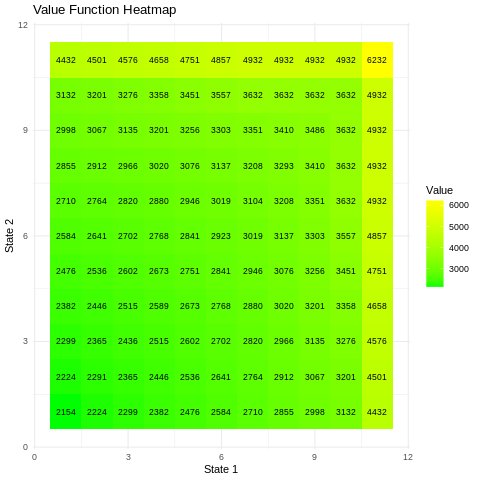

In [6]:
%%R
# 最適ポリシーのヒートマップ
policy_matrix <- matrix(op.2, nrow = sta, ncol = sta, byrow = TRUE)
policy_df <- melt(policy_matrix)  # reshape2 の melt 関数を使用
names(policy_df) <- c("State1", "State2", "Policy")

ggplot(policy_df, aes(x = State1, y = State2, fill = Policy)) +
  geom_tile() +
  geom_text(aes(label = Policy), color = "white", size = 3) +  # 数値を追加
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = median(policy_df$Policy)) +
  theme_minimal() +
  labs(title = "Optimal Policy Heatmap", x = "State 1", y = "State 2", fill = "Policy")

# 価値関数のヒートマップ
value_matrix <- matrix(v.2, nrow = sta, ncol = sta, byrow = TRUE)
value_df <- melt(value_matrix)  # reshape2 の melt 関数を使用
names(value_df) <- c("State1", "State2", "Value")

ggplot(value_df, aes(x = State1, y = State2, fill = Value)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.0f", Value)), color = "black", size = 3) +  # 数値を追加、小数点以下2桁で表示
  scale_fill_gradient(low = "green", high = "yellow") +
  theme_minimal() +
  labs(title = "Value Function Heatmap", x = "State 1", y = "State 2", fill = "Value")


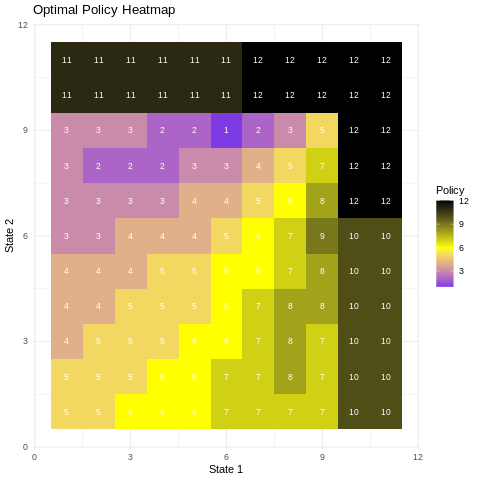

In [7]:
%%R

# 最適ポリシーのヒートマップの作成
policy_matrix <- matrix(op.2, nrow = sta, ncol = sta, byrow = TRUE)
policy_df <- melt(policy_matrix)  # reshape2 の melt 関数を使用
names(policy_df) <- c("State1", "State2", "Policy")

# ggplot2 を使った可視化
ggplot(policy_df, aes(x = State1, y = State2, fill = Policy)) +
  geom_tile() +
  geom_text(aes(label = Policy), color = "white", size = 3) +  # 数値も表示
  scale_fill_gradient2(low = "blue", high = "black", mid = "yellow", midpoint = median(policy_df$Policy)) +
  theme_minimal() +
  labs(title = "Optimal Policy Heatmap", x = "State 1", y = "State 2", fill = "Policy")
